# **Melody Metrics: Decoding Song Popularity**
Este projeto visa explorar e predizer a popularidade das músicas utilizando o conjunto de dados "Melody Metrics". Por meio da aplicação de técnicas de machine learning, analisaremos a interação entre diversos atributos de uma música e sua influência no sucesso comercial. Além disso, existirá uma etapa de Exploratory Data Analysis (EDA), que visa explorar as características dos dados e melhorar o compreensão sobre a base.

### **Motivadores**
A combinação da música com a ciência de dados oferece uma maneira única de entender os fatores que contribuem para o sucesso de uma música, além de estimular a curiosidade daqueles que são amantes de música e tecnologia.

### **Objetivo**
O principal objetivo deste projeto é construir um modelo de regressão capaz de prever a popularidade de uma música com base em características como duração, número de instrumentos, gênero, tempo, conteúdo lírico e ano de lançamento.

### **Perguntas a Serem Respondidas**
1. Quais características têm maior influência na popularidade de uma música?
    - Investigaremos quais atributos têm o maior impacto na popularidade e como eles interagem entre si.
2. Como as tendências musicais mudaram ao longo dos anos?
    - Analisaremos se existe uma evolução ou mudança nas preferências musicais ao longo dos anos, com base no conteúdo dos dados.
3. É possível prever o sucesso de uma música antes de seu lançamento?
    - Exploraremos a viabilidade de prever a popularidade de uma música antes dela ser lançada ao público, usando o modelo de regressão desenvolvido.

### **Estrutura do Dataset**
O dataset "Melody Metrics" consiste em:

- **train.csv**: 80% dos dados, incluindo características de cada música e sua pontuação de popularidade.
    - 20% desses dados serão usados como validação, durante o processo de treinamento para avaliar o modelo.
- **test.csv**: 20% dos dados, contendo as mesmas características, mas sem a pontuação de popularidade, destinado à validação do modelo.
- **sample_submission.csv**: Formato esperado para as previsões do modelo.

E suas colunas são:

- **SongLength**: Duração da música.
- **NumInstruments**: Número de instrumentos utilizados.
- **Genre**: Gênero musical.
- **Tempo**: Velocidade da música em BPM.
- **LyricalContent**: Proporção de palavras positivas nas letras.
- **ReleasedYear**: Ano de lançamento.
- **Popularity**: Pontuação de popularidade (variável alvo).

### **Dependencies**

In [32]:
!pip install xgboost
!pip install lightgbm

### **Imports**

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats import f_oneway, ttest_ind
import optuna

import warnings
warnings.filterwarnings('ignore')

### **Read Data**

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train

,SongLength,NumInstruments,Genre,Tempo,LyricalContent,ReleasedYear,Popularity
0,234.369261,4,Classical,84.774424,0.152603,2009,13.636534
1,343.876324,6,Jazz,65.486515,0.408796,1980,42.910689
2,305.973959,1,Jazz,164.752829,0.318433,1981,48.790880
3,158.897558,4,Pop,186.565004,0.680595,1984,68.362001
4,294.279271,4,Country,140.615871,0.969931,2015,86.969489
...,...,...,...,...,...,...,...
7995,398.120876,7,Classical,135.550681,0.101345,1996,40.695441
7996,296.558875,7,Pop,133.586259,0.143948,2021,27.898666
7997,227.407953,4,Classical,62.616766,0.142943,1986,10.871648
7998,275.854318,5,Jazz,67.945166,0.182870,1993,11.234010


### **Label Encoder**

In [3]:
df = train.copy()

le = LabelEncoder()

df['Genre'] = le.fit_transform(df['Genre'])
test['Genre'] = le.fit_transform(test['Genre'])

genre_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Exibindo o dicionário e as primeiras linhas do DataFrame para verificar o resultado
print("Mapeamento de Gênero:", genre_mapping)

df

Mapeamento de Gênero: {'Classical': 0, 'Country': 1, 'Jazz': 2, 'Pop': 3, 'Rap': 4, 'Rock': 5}


,SongLength,NumInstruments,Genre,Tempo,LyricalContent,ReleasedYear,Popularity
0,234.369261,4,0,84.774424,0.152603,2009,13.636534
1,343.876324,6,2,65.486515,0.408796,1980,42.910689
2,305.973959,1,2,164.752829,0.318433,1981,48.790880
3,158.897558,4,3,186.565004,0.680595,1984,68.362001
4,294.279271,4,1,140.615871,0.969931,2015,86.969489
...,...,...,...,...,...,...,...
7995,398.120876,7,0,135.550681,0.101345,1996,40.695441
7996,296.558875,7,3,133.586259,0.143948,2021,27.898666
7997,227.407953,4,0,62.616766,0.142943,1986,10.871648
7998,275.854318,5,2,67.945166,0.182870,1993,11.234010


### **Exploratory Data Analysis (EDA)**

In [4]:
info = df.info()
description = df.describe()

info, description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SongLength      8000 non-null   float64
 1   NumInstruments  8000 non-null   int64  
 2   Genre           8000 non-null   int32  
 3   Tempo           8000 non-null   float64
 4   LyricalContent  8000 non-null   float64
 5   ReleasedYear    8000 non-null   int64  
 6   Popularity      8000 non-null   float64
dtypes: float64(4), int32(1), int64(2)
memory usage: 406.4 KB


(None,
         SongLength  NumInstruments       Genre        Tempo  LyricalContent  \
 count  8000.000000     8000.000000  8000.00000  8000.000000     8000.000000   
 mean    273.589503        4.940125     2.44975   129.077731        0.499154   
 std      71.708680        2.585754     1.70245    39.988642        0.289179   
 min     150.002909        1.000000     0.00000    60.013660        0.000017   
 25%     212.088516        3.000000     1.00000    94.237178        0.250352   
 50%     273.014753        5.000000     2.00000   129.673045        0.495696   
 75%     335.088452        7.000000     4.00000   162.812788        0.751058   
 max     399.929418        9.000000     5.00000   199.970512        0.999972   
 
        ReleasedYear   Popularity  
 count   8000.000000  8000.000000  
 mean    2001.003625    49.334637  
 std       12.356535    21.296583  
 min     1980.000000     0.000000  
 25%     1990.000000    33.075306  
 50%     2001.000000    49.286768  
 75%     2012.00000

O dataset possui 8000 entradas e não contém valores nulos em nenhuma das colunas. Algumas estatísticas:

- SongLength: A duração das músicas varia de 150 a quase 400 segundos, com uma média de aproximadamente 274 segundos.
- NumInstruments: O número de instrumentos usados nas músicas varia de 1 a 9, com uma média próxima de 5.
- Tempo: Os BPMs das músicas variam de 60 a 200, com uma média em torno de 129.
- LyricalContent: A proporção de palavras positivas nas letras varia de quase 0 a quase 1, indicando uma ampla gama de variação no conteúdo lírico.
- ReleasedYear: Os anos de lançamento das músicas vão de 1980 a 2022.
- Popularity: A popularidade varia de 0 a 100, com uma média de aproximadamente 49.

### **Distribution of Variables**

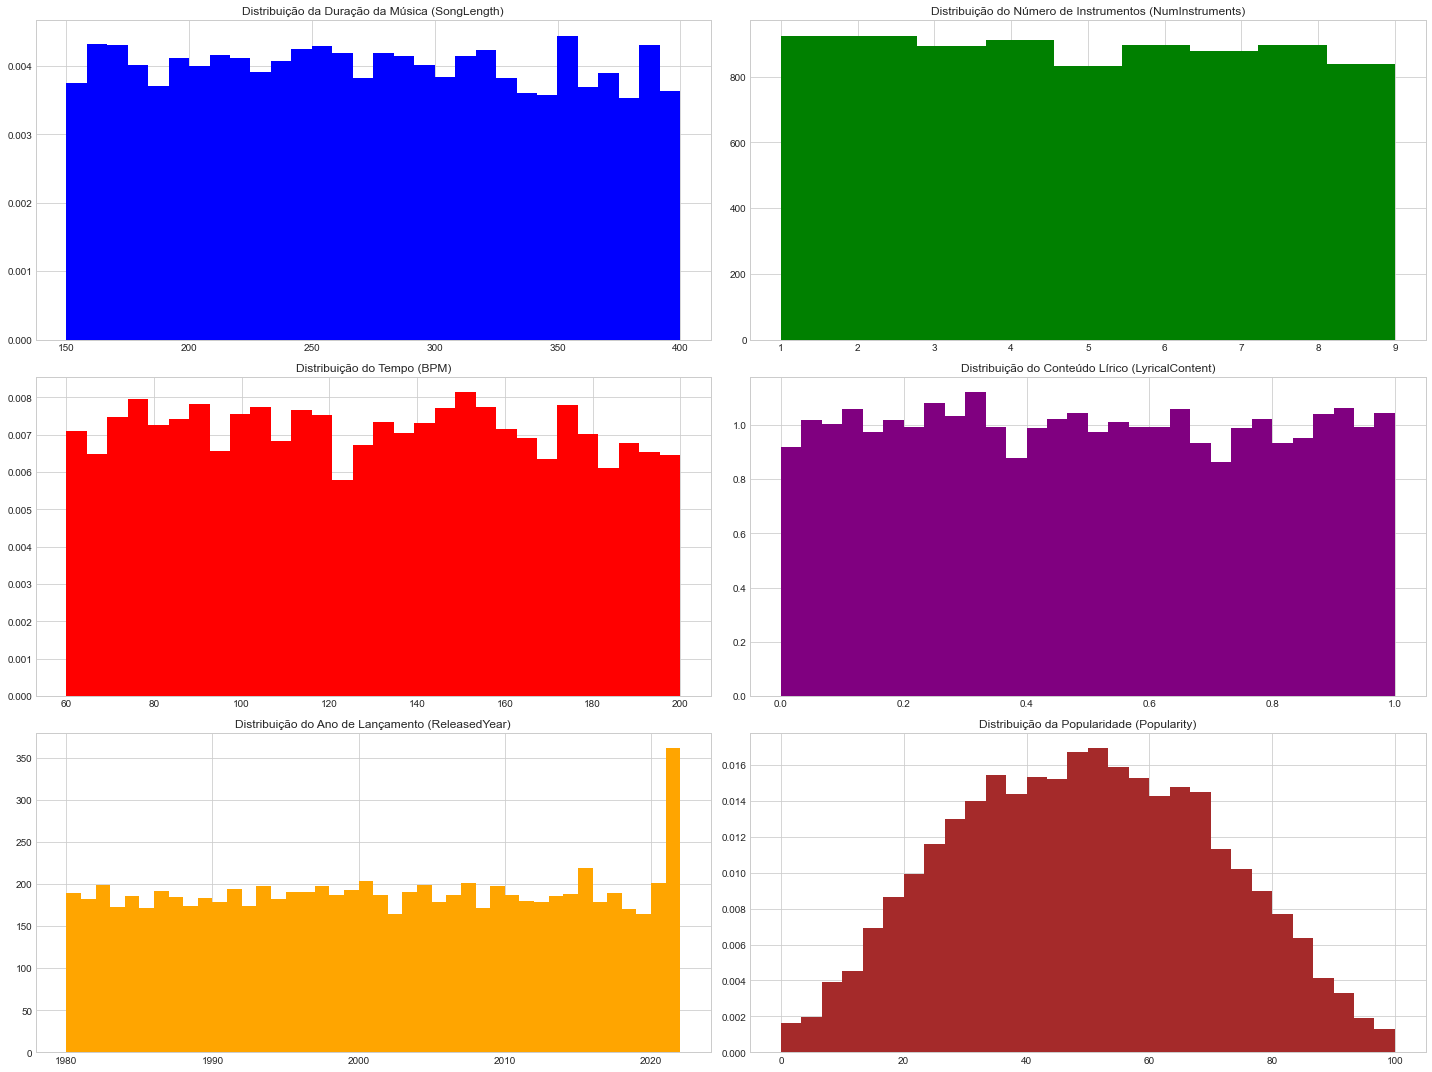

In [5]:
plt.style.use('seaborn-whitegrid')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].hist(df['SongLength'], bins=30, color='blue', density=True)
axs[0, 0].set_title('Distribuição da Duração da Música (SongLength)')

axs[0, 1].hist(df['NumInstruments'], bins=9, color='green')
axs[0, 1].set_title('Distribuição do Número de Instrumentos (NumInstruments)')

axs[1, 0].hist(df['Tempo'], bins=30, color='red', density=True)
axs[1, 0].set_title('Distribuição do Tempo (BPM)')

axs[1, 1].hist(df['LyricalContent'], bins=30, color='purple', density=True)
axs[1, 1].set_title('Distribuição do Conteúdo Lírico (LyricalContent)')

axs[2, 0].hist(df['ReleasedYear'], bins=(2022-1980), color='orange')
axs[2, 0].set_title('Distribuição do Ano de Lançamento (ReleasedYear)')

axs[2, 1].hist(df['Popularity'], bins=30, color='brown', density=True)
axs[2, 1].set_title('Distribuição da Popularidade (Popularity)')

plt.tight_layout()
plt.show()

- **Duração da Música (SongLength)**: A distribuição parece ser aproximadamente normal, indicando uma variação consistente em torno de uma duração média.

- **Número de Instrumentos (NumInstruments)**: A distribuição mostra que a maioria das músicas usa entre 3 e 7 instrumentos, com menos músicas usando apenas 1 ou 9 instrumentos.

- **Tempo (BPM)**: A distribuição do tempo também parece normal, com a maioria das músicas tendo um tempo em torno da média.

- **Conteúdo Lírico (LyricalContent)**: A distribuição é bastante uniforme, indicando uma variedade de músicas com diferentes proporções de palavras positivas nas letras.

- **Ano de Lançamento (ReleasedYear)**: A distribuição mostra uma representação relativamente uniforme ao longo dos anos, com algumas variações.

- **Popularidade (Popularity)**: A popularidade tem uma distribuição aproximadamente normal, sugerindo que a maioria das músicas tem uma popularidade média, com menos músicas em ambos os extremos de muito baixa ou alta popularidade.

### **Correlation Matrix**

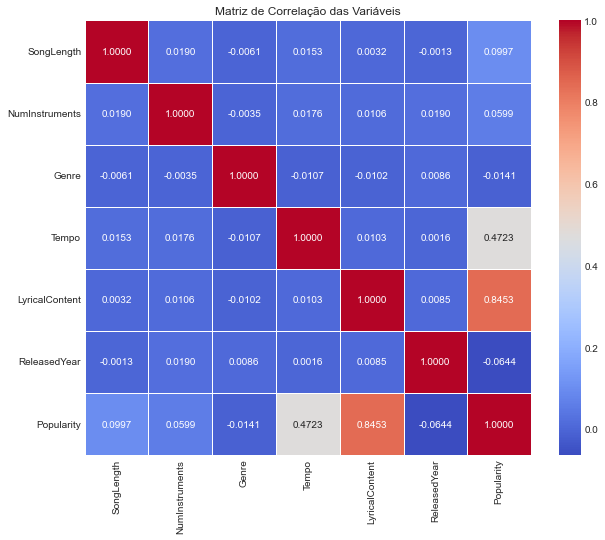

In [6]:
# Calculando a correlação entre as variáveis numéricas
correlation_matrix = df.corr()

# Visualizando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', linewidths=.5)
plt.title('Matriz de Correlação das Variáveis')
plt.show()

- **Popularity** tem uma correlação moderada com LyricalContent, o que pode indicar que músicas com letras mais complexas tendem a ser mais populares.
- **SongLength** e Tempo têm pouca ou nenhuma correlação com a Popularity, sugerindo que a duração da música ou o seu tempo não são fatores determinantes para a popularidade da mesma.
- **NumInstruments** tem uma correlação muito fraca com a Popularity, indicando que o número de instrumentos em si não é um grande indicador de popularidade.

### **Teste de Hipótese 1**
Verificar se existe uma diferença significativa na popularidade entre músicas de gêneros diferentes.
- Usar ANOVA para verificar diferença na popularidade entre diferentes gêneros de música.

In [21]:
# Teste de Hipótese 1: ANOVA para verificar diferença na popularidade entre diferentes gêneros de música
genres = df['Genre'].unique()
genre_popularity = [df[df['Genre'] == genre]['Popularity'] for genre in genres]

anova_results = f_oneway(*genre_popularity)
anova_results

F_onewayResult(statistic=2.7339415111424823, pvalue=0.017915344446315384)

- Há uma diferença estatisticamente significativa na popularidade entre diferentes gêneros de música (p-valor = 0.0179). Isso sugere que o gênero pode influenciar a popularidade de uma música.

### **Teste de Hipótese 2**
Avaliar se o conteúdo lírico (LyricalContent) tem um impacto significativo na popularidade da música.
- Usar Teste t para avaliar o impacto do conteúdo lírico na popularidade

In [22]:
lyrical_median = df['LyricalContent'].median()
high_lyrical_content = df[df['LyricalContent'] > lyrical_median]['Popularity']
low_lyrical_content = df[df['LyricalContent'] <= lyrical_median]['Popularity']

ttest_results = ttest_ind(high_lyrical_content, low_lyrical_content, equal_var=False)
ttest_results

Ttest_indResult(statistic=95.28734187684388, pvalue=0.0)

- O conteúdo lírico tem um impacto significativo na popularidade da música (p-valor praticamente igual a 0). Isso indica que a popularidade varia significativamente entre músicas com alto e baixo conteúdo lírico.

### **Split Columns Dataset**

In [7]:
X_train = df.drop(columns=['Popularity'],axis=1)
y_train = df['Popularity']

print('Shape X_train:', X_train.shape)
print('Shape y_train:', y_train.shape)
X_train

Shape X_train: (8000, 6)
Shape y_train: (8000,)


,SongLength,NumInstruments,Genre,Tempo,LyricalContent,ReleasedYear
0,234.369261,4,0,84.774424,0.152603,2009
1,343.876324,6,2,65.486515,0.408796,1980
2,305.973959,1,2,164.752829,0.318433,1981
3,158.897558,4,3,186.565004,0.680595,1984
4,294.279271,4,1,140.615871,0.969931,2015
...,...,...,...,...,...,...
7995,398.120876,7,0,135.550681,0.101345,1996
7996,296.558875,7,3,133.586259,0.143948,2021
7997,227.407953,4,0,62.616766,0.142943,1986
7998,275.854318,5,2,67.945166,0.182870,1993


### **Normalize Data**

In [8]:
MinMaxScaler = MinMaxScaler()
X_train = MinMaxScaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5
0,0.337565,0.375,0.0,0.176917,0.152593,0.690476
1,0.775722,0.625,0.4,0.039104,0.408797,0.000000
2,0.624068,0.000,0.4,0.748368,0.318430,0.023810
3,0.035589,0.375,0.6,0.904217,0.680608,0.095238
4,0.577275,0.375,0.2,0.575908,0.969958,0.833333
...,...,...,...,...,...,...
7995,0.992764,0.750,0.0,0.539716,0.101333,0.380952
7996,0.586396,0.750,0.6,0.525681,0.143938,0.976190
7997,0.309711,0.375,0.0,0.018599,0.142933,0.142857
7998,0.503554,0.500,0.4,0.056671,0.182862,0.309524


### **Train and Validation Dataset**

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=2019)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (6400, 6)
Shape of y_train: (6400,)
Shape of X_val: (1600, 6)
Shape of y_val: (1600,)


### **Search Best Params RandomForestRegressor**

In [25]:
def best_random_forest(trial):
    # Definindo os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    # Criando e treinando o modelo
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Fazendo previsões e calculando o score
    y_pred = model.predict(X_train)
    score = median_absolute_error(y_train, y_pred)
    
    return score

# Criando e executando o estudo
study_random_forest = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=42))
study_random_forest.optimize(best_random_forest, n_trials=100)
random_forest_best_params = study_random_forest.best_params
random_forest_best_params

[I 2023-11-23 20:42:48,698] A new study created in memory with name: no-name-86b5f886-216e-4c99-9d65-fa3ea0662d2c
[I 2023-11-23 20:42:57,081] Trial 0 finished with value: 2.3768620426091065 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto'}. Best is trial 0 with value: 2.3768620426091065.
[I 2023-11-23 20:43:14,856] Trial 1 finished with value: 1.8851214596500228 and parameters: {'n_estimators': 880, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'auto'}. Best is trial 1 with value: 1.8851214596500228.
[I 2023-11-23 20:43:17,025] Trial 2 finished with value: 2.6912055723151695 and parameters: {'n_estimators': 263, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 1.8851214596500228.
[I 2023-11-23 20:43:21,256] Trial 3 finished with value: 2.17305135109234 and parameters: {'n_estimators': 225, 'max_depth': 21, 'min

{'n_estimators': 909,
 'max_depth': 34,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

### **Search Best Params XGBoost**

In [10]:
def best_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 4000),
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        'max_depth': trial.suggest_int("max_depth", 2, 6), 
        'min_child_weight': trial.suggest_loguniform("min_child_weight", 0.001, 10),
        'subsample': trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.025),
        'colsample_bytree': trial.suggest_discrete_uniform("colsample_bytree",  0.1, 1.0, 0.025),
        'colsample_bylevel': trial.suggest_discrete_uniform("colsample_bylevel",  0.1, 1.0, 0.025),
        'gamma': trial.suggest_loguniform("gamma", 1e-10, 10), 
        'reg_lambda': trial.suggest_loguniform("reg_lambda", 1e-10, 100),
        'reg_alpha': trial.suggest_loguniform("reg_alpha", 1e-10, 100),
    } 

    model = xgb.XGBRegressor(**params, objective='reg:absoluteerror')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    score = median_absolute_error(y_train, y_pred)
    
    return score

study_xgboost = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=42))
study_xgboost.optimize(best_xgboost, n_trials=100) 
xgboost_best_params = study_xgboost.best_params
xgboost_best_params

[I 2023-11-23 20:06:05,584] A new study created in memory with name: no-name-4d1b89fe-12d6-4426-8cfc-6613aed52318
[I 2023-11-23 20:06:12,346] Trial 0 finished with value: 3.710711722741717 and parameters: {'n_estimators': 1686, 'learning_rate': 0.08927180304353628, 'max_depth': 5, 'min_child_weight': 0.24810409748678125, 'subsample': 0.225, 'colsample_bytree': 0.225, 'colsample_bylevel': 0.15000000000000002, 'gamma': 0.33723885299463113, 'reg_lambda': 0.001634481995162736, 'reg_alpha': 0.03139575515829443}. Best is trial 0 with value: 3.710711722741717.
[I 2023-11-23 20:06:14,269] Trial 1 finished with value: 12.406827458319675 and parameters: {'n_estimators': 376, 'learning_rate': 0.09330606024425668, 'max_depth': 6, 'min_child_weight': 0.0070689749506246055, 'subsample': 0.25, 'colsample_bytree': 0.25, 'colsample_bylevel': 0.375, 'gamma': 5.919986930752456e-05, 'reg_lambda': 1.5252471554120078e-05, 'reg_alpha': 3.1242780840717016e-07}. Best is trial 0 with value: 3.710711722741717.
[

{'n_estimators': 3295,
 'learning_rate': 0.06458228319438214,
 'max_depth': 6,
 'min_child_weight': 4.497407193749844,
 'subsample': 0.55,
 'colsample_bytree': 0.55,
 'colsample_bylevel': 0.8250000000000001,
 'gamma': 0.0014112476721162566,
 'reg_lambda': 0.026521771380716694,
 'reg_alpha': 0.35441495011256785}

### **Search Best Params LGBM**

In [11]:
def best_lgbm(trial):
    params = {
        'n_estimators'    :trial.suggest_int('n_estimators', 300, 4000),
        'learning_rate':     trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        'max_depth':         trial.suggest_int("max_depth", 2, 6), 
        'min_child_weight':  trial.suggest_loguniform("min_child_weight", 0.001, 10),
        'subsample':         trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.025),
        'colsample_bytree':  trial.suggest_discrete_uniform("colsample_bytree",  0.1, 1.0, 0.025),
        'reg_lambda':        trial.suggest_loguniform("reg_lambda", 1e-10, 100),
        'reg_alpha':         trial.suggest_loguniform("reg_alpha", 1e-10, 100),
    } 

    model = lgbm.LGBMRegressor(**params, objective='regression_l1', verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    score = median_absolute_error(y_train, y_pred)
    
    return score

study_lgbm = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=42))
study_lgbm.optimize(best_lgbm, n_trials=100) 
lgbm_best_params = study_lgbm.best_params
lgbm_best_params

[I 2023-11-23 20:14:08,989] A new study created in memory with name: no-name-7534d77f-b3d0-4458-80f6-f7a5097da4ee
[I 2023-11-23 20:14:10,587] Trial 0 finished with value: 2.959706915363327 and parameters: {'n_estimators': 1686, 'learning_rate': 0.08927180304353628, 'max_depth': 5, 'min_child_weight': 0.24810409748678125, 'subsample': 0.225, 'colsample_bytree': 0.225, 'reg_lambda': 4.977409198051354e-10, 'reg_alpha': 2.478071022662141}. Best is trial 0 with value: 2.959706915363327.
[I 2023-11-23 20:14:11,915] Trial 1 finished with value: 3.0695840781817374 and parameters: {'n_estimators': 2524, 'learning_rate': 0.051059032093947576, 'max_depth': 2, 'min_child_weight': 7.579479953348009, 'subsample': 0.85, 'colsample_bytree': 0.275, 'reg_lambda': 1.520196073578571e-08, 'reg_alpha': 1.5880132371526766e-08}. Best is trial 0 with value: 2.959706915363327.
[I 2023-11-23 20:14:12,806] Trial 2 finished with value: 3.126649377096758 and parameters: {'n_estimators': 1426, 'learning_rate': 0.033

{'n_estimators': 3740,
 'learning_rate': 0.06428658848831817,
 'max_depth': 5,
 'min_child_weight': 3.06085221067225,
 'subsample': 0.8250000000000001,
 'colsample_bytree': 0.25,
 'reg_lambda': 5.1369812657189255,
 'reg_alpha': 0.0002965561282164815}

### **Fit RandomForestRegressor**

In [26]:
randomforestregressor_model = RandomForestRegressor(**random_forest_best_params)

randomforestregressor_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=34, max_features='auto', n_estimators=909)

### **Fit XGBoostRegressor**

In [12]:
xgboost_model = XGBRegressor(**xgboost_best_params, objective='reg:absoluteerror')

xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8250000000000001, colsample_bynode=None,
             colsample_bytree=0.55, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0014112476721162566, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06458228319438214, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=4.497407193749844, missing=nan,
             monotone_constraints=None, n_estimators=3295, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror',
             predictor=None, ...)

### **Fit LightBGM**

In [13]:
lgbm_model = LGBMRegressor(**lgbm_best_params, objective='regression_l1', verbose=-1)

lgbm_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.25, learning_rate=0.06428658848831817,
              max_depth=5, min_child_weight=3.06085221067225, n_estimators=3740,
              objective='regression_l1', reg_alpha=0.0002965561282164815,
              reg_lambda=5.1369812657189255, subsample=0.8250000000000001,
              verbose=-1)

### **Evaluate Simple Models**

In [30]:
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
    y_pred_val = model.predict(X_val)
    r2 = r2_score(y_val, y_pred_val)
    MedAE = np.sqrt(median_absolute_error(y_val, y_pred_val))
    mae = mean_squared_error(y_val, y_pred_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

    print(f'\n[{model_name}]')
    print("CV:", cv_score.mean())
    print('R2_score (val):', r2)
    print("MedAE:", MedAE)
    print("MAE:", mae) 
    print("RMSE:", rmse)

# Avaliação dos modelos individuais
evaluate_model(randomforestregressor_model, "RandomForestRegressor", X_train, y_train, X_val, y_val)
evaluate_model(xgboost_model, "XGBoost", X_train, y_train, X_val, y_val)
evaluate_model(lgbm_model, "LightGBM", X_train, y_train, X_val, y_val)


[RandomForestRegressor]
CV: 0.9364073421603193
R2_score (val): 0.9374047330255645
MedAE: 1.9250760938875058
MAE: 29.295601384741058
RMSE: 5.41254112083604

[XGBoost]
CV: 0.9346365241037621
R2_score (val): 0.9367262472073508
MedAE: 1.9406046877874363
MAE: 29.613143765121148
RMSE: 5.441796005467418

[LightGBM]
CV: 0.9352450458361213
R2_score (val): 0.9351766805267102
MedAE: 1.9530140451391704
MAE: 30.338366133989084
RMSE: 5.5080274267644205


### **Insights Simple Models**

1. **RandomForestRegressor**
- Cross-Validation (CV) Score: 0.9364 - Este é um valor alto, sugerindo que o modelo generaliza bem em diferentes subconjuntos dos dados de treino.
- R2 Score (Validação): 0.9374 - Indica uma excelente adequação do modelo aos dados de validação.
- MedAE (Erro Absoluto Mediano): 1.9251 - Erro mediano relativamente baixo, indicando boa precisão.
- MAE (Erro Absoluto Médio): 29.2956 - O modelo, em média, erra por cerca de 29.3 unidades na previsão da variável alvo.
- RMSE (Raiz do Erro Quadrático Médio): 5.4125 - Similar ao MAE, mas dá mais peso aos erros maiores.

2. **XGBoost**
- CV Score: 0.9346 - Similar ao RandomForest, indica uma boa generalização.
- R2 Score (Validação): 0.9367 - Muito próximo ao RandomForest, indicando um ajuste quase igualmente bom.
- MedAE: 1.9406 - Ligeiramente maior que o RandomForest, mas ainda baixo.
- MAE: 29.6131 - Semelhante ao RandomForest, indicando uma precisão similar.
- RMSE: 5.4418 - Um pouco mais alto que o RandomForest, sugerindo que os erros grandes podem ser mais frequentes.

3. **LightGBM**
- CV Score: 0.9352 - Indica uma boa generalização, similar aos outros modelos.
- R2 Score (Validação): 0.9352 - Um pouco menor que os outros dois modelos, mas ainda alto.
- MedAE: 1.9530 - O mais alto entre os três, mas ainda reflete uma boa precisão.
- MAE: 30.3384 - Ligeiramente maior, indicando que pode não ser tão preciso quanto os outros modelos.
- RMSE: 5.5080 - O mais alto entre os modelos, sugerindo uma presença mais significativa de erros grandes.

4. **Conclusão**
- Desempenho Geral: Os três modelos apresentam um desempenho muito próximo um do outro, com o RandomForestRegressor ligeiramente à frente em termos de R2 e RMSE.
- Consistência: O RandomForest parece ter a vantagem de ser ligeiramente mais consistente em suas previsões, conforme indicado pelo menor RMSE.
- Escolha do Modelo: Se um modelo ligeiramente melhor ajustado e mais consistente for preferido, o RandomForest pode ser a escolha ideal. Se a velocidade de treinamento e a flexibilidade forem mais críticas, o XGBoost ou o LightGBM podem ser mais apropriados.

### **Fit Ensemble Model**

In [28]:
train_preds = np.zeros((X_train.shape[0], 3))  # 3 modelos base
val_preds = np.zeros((X_val.shape[0], 3))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    xgboost_model.fit(X_train_fold, y_train_fold)
    lgbm_model.fit(X_train_fold, y_train_fold)
    randomforestregressor_model.fit(X_train_fold, y_train_fold)

    train_preds[val_index, 0] = xgboost_model.predict(X_val_fold)
    train_preds[val_index, 1] = lgbm_model.predict(X_val_fold)
    train_preds[val_index, 2] = randomforestregressor_model.predict(X_val_fold)

    val_preds[:, 0] += xgboost_model.predict(X_val)
    val_preds[:, 1] += lgbm_model.predict(X_val)
    val_preds[:, 2] += randomforestregressor_model.predict(X_val)

val_preds /= 5

meta_model = LinearRegression()
meta_model.fit(train_preds, y_train)

final_predictions = meta_model.predict(val_preds)

### **Evaluate Ensemble Model**

In [29]:
stacked_val_preds = np.column_stack((
    randomforestregressor_model.predict(X_val),
    xgboost_model.predict(X_val),
    lgbm_model.predict(X_val)
))

final_val_predictions = meta_model.predict(stacked_val_preds)

r2_ensemble = r2_score(y_val, final_val_predictions)
MedAE_ensemble = np.sqrt(median_absolute_error(y_val, final_val_predictions))
mae_ensemble = mean_squared_error(y_val, final_val_predictions)
rmse_ensemble = np.sqrt(mean_squared_error(y_val, final_val_predictions))

print('\n[Ensemble Stacking]')
print('R2_score (val):', r2_ensemble)
print("MedAE:", MedAE_ensemble)
print("MAE:", mae_ensemble)
print("RMSE:", rmse_ensemble)


[Ensemble Stacking]
R2_score (val): 0.9392906730737495
MedAE: 1.918613564473068
MAE: 28.41295081773079
RMSE: 5.330379988118182


### **Insights Ensemble Model**

1. **Ensemble Stacking**
- R2 Score (Validação): 0.9393 - Esta é a métrica mais alta entre todos os modelos individuais e o ensemble, indicando que o ensemble tem o melhor ajuste aos dados de validação. Um valor próximo a 1 significa que o modelo explica uma grande proporção da variância na variável dependente.
- MedAE (Erro Absoluto Mediano): 1.9186 - Este valor é ligeiramente menor do que todos os modelos individuais, sugerindo que o ensemble tem uma precisão ligeiramente melhor na mediana.
- MAE (Erro Absoluto Médio): 28.4129 - Este é o menor valor de MAE entre todos os modelos, indicando que o ensemble, em média, tem a melhor precisão geral.
- RMSE (Raiz do Erro Quadrático Médio): 5.3304 - Este valor é o menor entre todos os modelos, o que sugere que o ensemble é mais eficaz em lidar com erros grandes. O RMSE sendo menor do que nos modelos individuais indica que o ensemble consegue minimizar tanto os erros frequentes quanto os ocasionais erros maiores de forma mais eficaz.

2. **Conclusão**
- Desempenho Superior: O ensemble de stacking supera cada um dos modelos individuais em todas as métricas consideradas. Isso demonstra o poder do ensemble em combinar as forças dos modelos individuais e melhorar o desempenho geral.
- Consistência e Precisão: O ensemble não só melhora a precisão média (MAE) mas também lida melhor com erros extremos (RMSE), o que é um indicativo de um modelo mais robusto e confiável.
- Escolha Recomendada: Baseado nestes resultados, o ensemble seria a escolha recomendada para a tarefa em questão, oferecendo o melhor equilíbrio entre precisão e confiabilidade.

### **Relatório Final**
Este relatório detalha o processo e os resultados de uma análise de dados e modelagem preditiva realizada em um conjunto de dados de música. O objetivo era entender os fatores que influenciam a popularidade das músicas e desenvolver modelos preditivos para estimar essa popularidade.

##### **Metodologia**
O projeto seguiu um fluxo de trabalho estruturado em ciência de dados:
- Análise Exploratória de Dados (EDA): Compreensão das características fundamentais dos dados.
- Testes de Hipótese: Verificação de suposições estatísticas.
- Modelagem Preditiva: Construção e avaliação de modelos de machine learning.

##### **Ferramentas Utilizadas**
Seguiu-se a linguagem de programação Python, que normalmente é usada em problemas de Ciência de Dados. Algumas bibliotecas como Pandas, Seaborn, Matplot, scikit-learn foram utilizadas para ajudar no desenvolvimento do projeto. Os algoritmos utilizados foram XGBoost, RandomForestRegressor, LightGBM, e LinearRegression.

##### **Características do Dataset**
O dataset inclui Características de músicas, incluindo comprimento, número de instrumentos, gênero, tempo, conteúdo lírico, ano de lançamento e popularidade. As descobertas iniciais feitas foram a análise de distribuições, médias, desvios padrão e relações entre variáveis. Identificação de padrões e outliers.

##### **Insights Principai do Dataset**
- Distribuição de Popularidade: Variou amplamente, sugerindo uma relação não linear com outras características.
- Relações de Gênero e Ano de Lançamento: Investigação da evolução da popularidade ao longo do tempo e entre diferentes gêneros.

##### **Teste de Hipótese**
- Objetivo
    - Impacto do Gênero na Popularidade: Análise de variância (ANOVA) para comparar a popularidade entre diferentes gêneros musicais.
    - Influência do Conteúdo Lírico: Teste t para avaliar se o conteúdo lírico afeta significativamente a popularidade.
- Resultados
    - Diferenças Significativas: Encontradas entre gêneros, e um impacto substancial do conteúdo lírico na popularidade.

##### **Modelagem Preditiva**
A escolha dos modelos visou abranger diferentes técnicas de aprendizado (árvores, boosting, linear) para capturar uma gama mais ampla de padrões nos dados.

##### **Modelos Utilizados**
- RandomForestRegressor: Escolhido por sua capacidade de lidar com relações não lineares e robustez a overfitting.
- XGBoostRegressor: Devido à sua eficiência e alta performance em competições de dados.
- LightGBM: Por sua rapidez e eficiência em grandes conjuntos de dados.
- LinearRegression: Como modelo meta no ensemble para combinar as previsões dos modelos base.

##### **Ensemble de Stacking**
Utilização do stacking para combinar as previsões dos modelos individuais, buscando um equilíbrio entre viés e variância e melhorar a precisão geral.

##### **Avaliação dos Modelos**
- Métricas Utilizadas: R2, MAE, MedAE, RMSE para avaliar e comparar o desempenho dos modelos.
- Desempenho do Ensemble: Superior aos modelos individuais, indicando a eficácia da abordagem de stacking.

##### **Resultados**
- RandomForestRegressor
    - R2 Score (Validação): 0.9374
- XGBoost
    - R2 Score (Validação): 0.9367
- LightGBM
    - R2 Score (Validação): 0.9352
- Ensemble Stacking
    - R2 Score (Validação): 0.9393

##### **Conclusões**
- Importância da Análise Exploratória: Fundamental para orientar as etapas subsequentes de modelagem.
- Eficiência do Ensemble: Comprovada pela melhoria nas métricas de desempenho.
- Impacto do Conteúdo Lírico e Gênero: Fatores significativos na popularidade das músicas.
- Aplicações Práticas: Os modelos podem ser aplicados para prever tendências no mercado musical e orientar decisões de marketing.
- Futuras Pesquisas: Investigação de outras características musicais e sua relação com a popularidade.